# **USD/HUF Currency Analysis and Option Pricing Project**

In [1]:
# Install the arch package
!pip install arch

# Import all required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from arch import arch_model
from datetime import datetime

# Apply seaborn style properly
sns.set()
%matplotlib inline


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.9 MB/s eta 0:00:00


### **1. Data Download and Preparation**

In [2]:
# Download USD/HUF data
ticker = "USDHUF=X"
data = yf.download(ticker, period="max")

# Clean the data - remove multi-index columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)

# Keep only necessary columns and rename
df = data[['Close']].copy()
df.columns = ['Price']

# Save to CSV
df.to_csv("USDHUF_historical.csv")

# Display data
print("Data Head:")
print(df.head())
print("\nData Tail:")
print(df.tail())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data Head:
                 Price
Date                  
2003-12-01  227.279999
2003-12-02  224.630005
2003-12-03  224.500000
2003-12-04  221.380005
2003-12-05  220.720001

Data Tail:
                 Price
Date                  
2025-04-15  361.273987
2025-04-16  361.080994
2025-04-17  357.506989
2025-04-22  353.649994
2025-04-23  358.269989


### **2. Plot Prices**

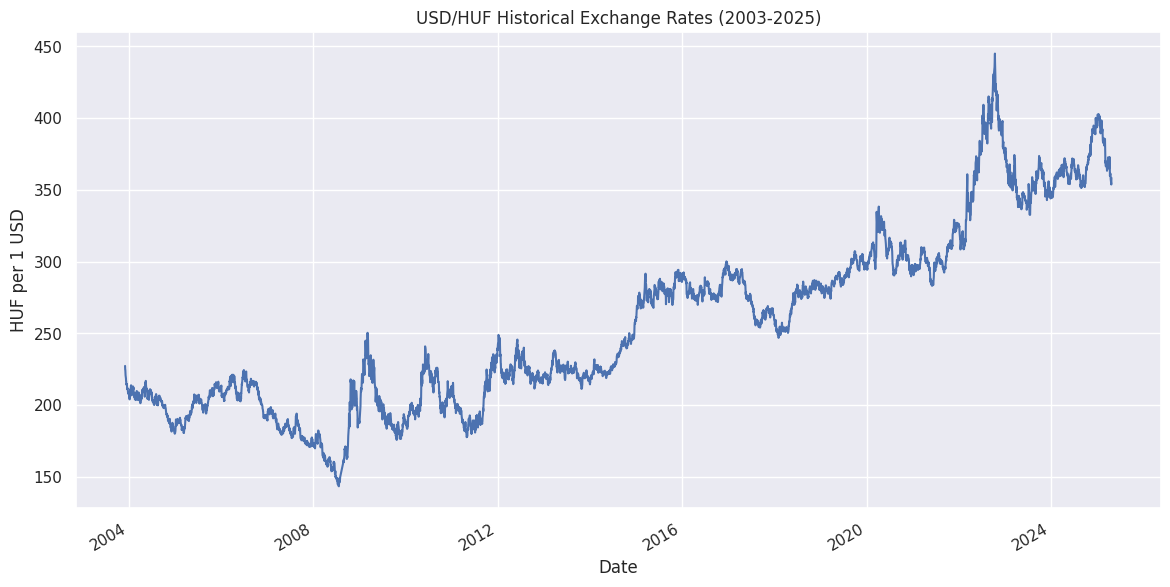

In [3]:
plt.figure(figsize=(14, 7))
df['Price'].plot(title='USD/HUF Historical Exchange Rates (2003-2025)', grid=True)
plt.ylabel('HUF per 1 USD')
plt.xlabel('Date')
plt.show()

### **3. Calculate and Plot Log Returns**

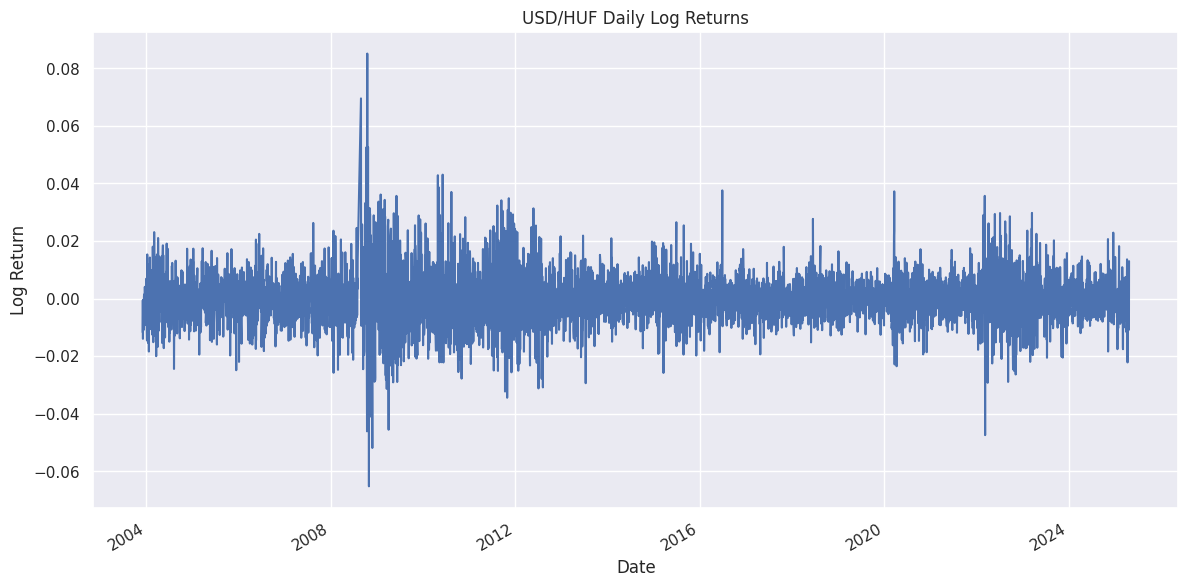

In [4]:
# Calculate daily log returns
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna()

# Plot log returns
plt.figure(figsize=(14, 7))
df['Log_Return'].plot(title='USD/HUF Daily Log Returns', grid=True)
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.show()

### **4. Normality Tests**

### **Histogram with Normal Distribution**

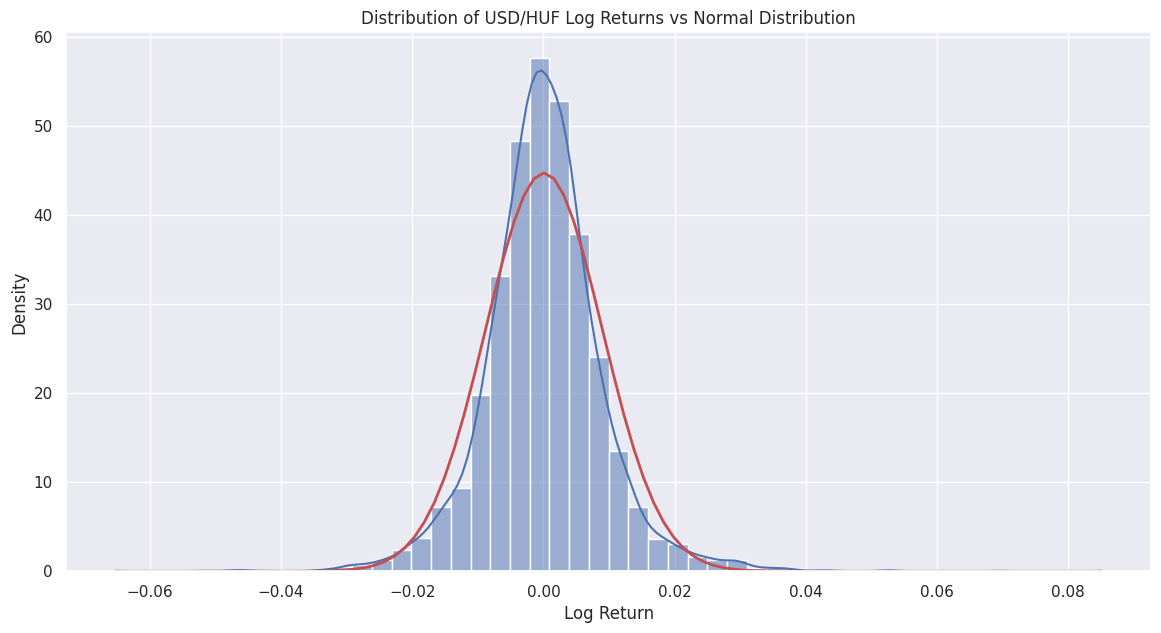

In [5]:
plt.figure(figsize=(14, 7))
sns.histplot(df['Log_Return'], kde=True, stat='density', bins=50)
x = np.linspace(df['Log_Return'].min(), df['Log_Return'].max(), 100)
plt.plot(x, stats.norm.pdf(x, df['Log_Return'].mean(), df['Log_Return'].std()), 'r', linewidth=2)
plt.title('Distribution of USD/HUF Log Returns vs Normal Distribution')
plt.xlabel('Log Return')
plt.show()

### **QQ Plot**

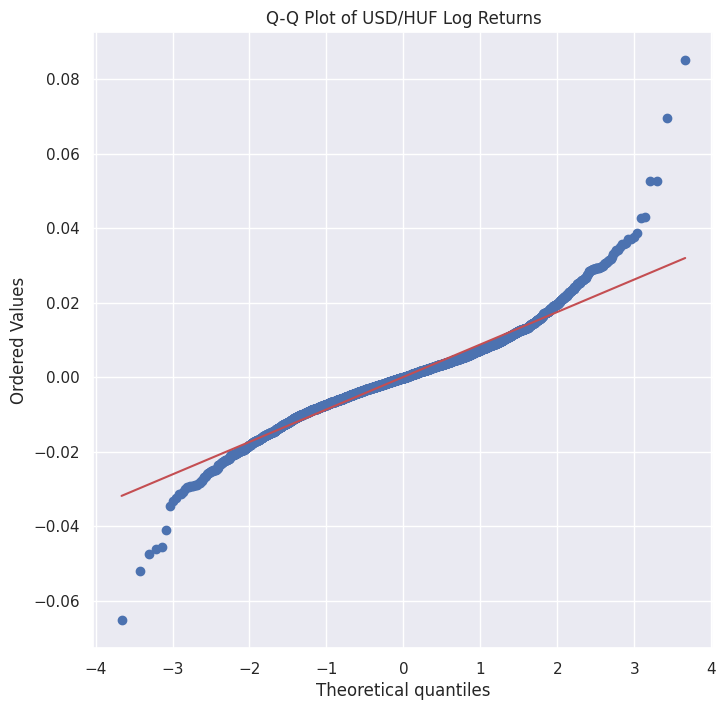

In [6]:
plt.figure(figsize=(8, 8))
stats.probplot(df['Log_Return'], dist="norm", plot=plt)
plt.title('Q-Q Plot of USD/HUF Log Returns')
plt.show()

### **Statistical Tests**

In [7]:
# Jarque-Bera test
jb_test = stats.jarque_bera(df['Log_Return'])
print(f"Jarque-Bera Test: statistic={jb_test[0]:.4f}, p-value={jb_test[1]:.4f}")

# Kolmogorov-Smirnov test
ks_test = stats.kstest(df['Log_Return'], 'norm',
                      args=(df['Log_Return'].mean(), df['Log_Return'].std()))
print(f"Kolmogorov-Smirnov Test: statistic={ks_test[0]:.4f}, p-value={ks_test[1]:.4f}")

# Anderson-Darling test
ad_test = stats.anderson(df['Log_Return'], dist='norm')
print(f"Anderson-Darling Test: statistic={ad_test.statistic:.4f}")
print("Critical values:", ad_test.critical_values)
print("Significance levels:", ad_test.significance_level)

Jarque-Bera Test: statistic=5959.0451, p-value=0.0000
Kolmogorov-Smirnov Test: statistic=0.0594, p-value=0.0000
Anderson-Darling Test: statistic=40.6734
Critical values: [0.576 0.656 0.786 0.917 1.091]
Significance levels: [15.  10.   5.   2.5  1. ]


### **5. Historical Volatility Calculation**

In [8]:
# Daily volatility
daily_volatility = df['Log_Return'].std()

# Annualized volatility (assuming 252 trading days)
annual_volatility = daily_volatility * np.sqrt(252)

print(f"Daily Volatility: {daily_volatility:.6f} or {daily_volatility*100:.4f}%")
print(f"Annualized Volatility: {annual_volatility:.6f} or {annual_volatility*100:.4f}%")

Daily Volatility: 0.008914 or 0.8914%
Annualized Volatility: 0.141512 or 14.1512%


### **6. Risk-Free Rates**

In [9]:
# Current 3-month rates (as of April 2025 - these need to be updated with current values)
usd_rf = 0.0535  # 5.35% for USD (3-month Treasury bill)
huf_rf = 0.0790  # 7.90% for HUF (3-month Hungarian government bond yield)

print(f"USD 3-month risk-free rate: {usd_rf*100:.2f}%")
print(f"HUF 3-month risk-free rate: {huf_rf*100:.2f}%")

USD 3-month risk-free rate: 5.35%
HUF 3-month risk-free rate: 7.90%


### **7. Independence/Uncorrelation Tests**

### **Autocorrelation Plot**

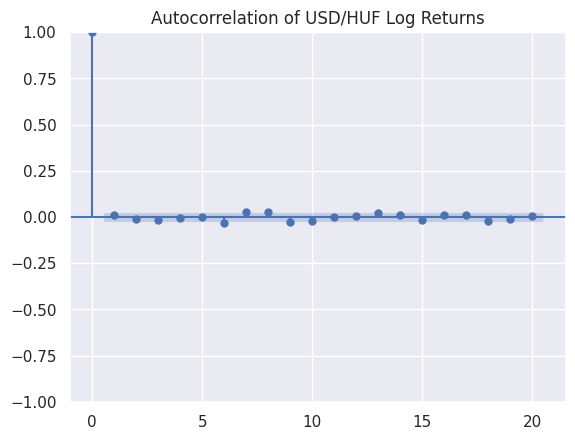

In [10]:
plot_acf(df['Log_Return'], lags=20, title='Autocorrelation of USD/HUF Log Returns')
plt.show()

### **Ljung-Box Test**

In [11]:
lb_test = acorr_ljungbox(df['Log_Return'], lags=10)
print("Ljung-Box Test p-values:")
print(lb_test.iloc[:,1].values)

Ljung-Box Test p-values:
[0.32018939 0.47539331 0.35611536 0.49843054 0.64348825 0.14201714
 0.06930713 0.03333495 0.01533815 0.00929314]


### **8-10. Option Pricing (ATM European Options**)

**Black-Scholes Model**

In [12]:
def black_scholes(S, K, T, r, q, sigma, option_type):
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if option_type == 'call':
        price = S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)
    return price

**CRR Binomial Model**

In [13]:
def crr_binomial(S, K, T, r, q, sigma, n, option_type):
    dt = T/n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp((r-q)*dt) - d) / (u - d)

    # Price tree
    price_tree = np.zeros((n+1, n+1))
    for i in range(n+1):
        price_tree[i, n] = S * (u**i) * (d**(n-i))

    # Option value tree
    option_tree = np.zeros((n+1, n+1))
    for i in range(n+1):
        if option_type == 'call':
            option_tree[i, n] = max(0, price_tree[i, n] - K)
        else:
            option_tree[i, n] = max(0, K - price_tree[i, n])

    # Backward induction
    for j in range(n-1, -1, -1):
        for i in range(j+1):
            option_tree[i, j] = np.exp(-r*dt) * (p*option_tree[i+1, j+1] + (1-p)*option_tree[i, j+1])

    return option_tree[0,0]

**Monte Carlo Simulation**

In [14]:
def monte_carlo(S, K, T, r, q, sigma, n_sim, option_type):
    np.random.seed(42)
    z = np.random.standard_normal(n_sim)
    ST = S * np.exp((r - q - 0.5*sigma**2)*T + sigma*np.sqrt(T)*z)

    if option_type == 'call':
        payoff = np.maximum(ST - K, 0)
    else:
        payoff = np.maximum(K - ST, 0)

    price = np.exp(-r*T) * np.mean(payoff)
    return price

**Calculate Option Prices**

In [15]:
# Current parameters
S = df['Price'].iloc[-1]  # current spot rate
K = S  # ATM option
today = datetime.today().date()
maturity = datetime(2025, 5, 31).date()
T = (maturity - today).days / 365  # time to maturity in years
r = usd_rf  # USD risk-free rate
q = huf_rf  # HUF risk-free rate (treated as dividend yield)
sigma = annual_volatility  # historical volatility

print(f"\nOption Pricing Parameters:")
print(f"Spot Price (S): {S:.4f} HUF/USD")
print(f"Strike Price (K): {K:.4f} HUF/USD")
print(f"Time to Maturity (T): {T:.4f} years")
print(f"USD Risk-Free Rate (r): {r*100:.2f}%")
print(f"HUF Risk-Free Rate (q): {q*100:.2f}%")
print(f"Volatility (σ): {sigma*100:.2f}%")

# Calculate prices with historical volatility
bs_call = black_scholes(S, K, T, r, q, sigma, 'call')
bs_put = black_scholes(S, K, T, r, q, sigma, 'put')

n = 100  # steps for binomial
crr_call = crr_binomial(S, K, T, r, q, sigma, n, 'call')
crr_put = crr_binomial(S, K, T, r, q, sigma, n, 'put')

n_sim = 100000  # simulations
mc_call = monte_carlo(S, K, T, r, q, sigma, n_sim, 'call')
mc_put = monte_carlo(S, K, T, r, q, sigma, n_sim, 'put')

# Create results table
results = pd.DataFrame({
    'Method': ['Black-Scholes', 'CRR Binomial', 'Monte Carlo'],
    'Call Price': [bs_call, crr_call, mc_call],
    'Put Price': [bs_put, crr_put, mc_put]
})

print("\nOption Prices with Historical Volatility:")
print(results)


Option Pricing Parameters:
Spot Price (S): 358.2700 HUF/USD
Strike Price (K): 358.2700 HUF/USD
Time to Maturity (T): 0.1041 years
USD Risk-Free Rate (r): 5.35%
HUF Risk-Free Rate (q): 7.90%
Volatility (σ): 14.15%

Option Prices with Historical Volatility:
          Method  Call Price  Put Price
0  Black-Scholes    6.019410   6.964005
1   CRR Binomial    6.003201   6.947797
2    Monte Carlo    6.034025   6.962276


### **10. GARCH Volatility Estimation**

In [16]:
# Fit GARCH(1,1) model
print("\nFitting GARCH(1,1) model...")
garch = arch_model(df['Log_Return']*100, mean='Constant', vol='GARCH', p=1, q=1)
garch_fit = garch.fit(update_freq=5)
print(garch_fit.summary())

# Forecast volatility
forecast = garch_fit.forecast(horizon=1)
garch_vol = np.sqrt(forecast.variance.iloc[-1,0]) / 100  # Convert back from percentage
annual_garch_vol = garch_vol * np.sqrt(252)

print(f"\nGARCH(1,1) Estimated Annual Volatility: {annual_garch_vol*100:.2f}%")

# Recalculate options with GARCH volatility
bs_call_garch = black_scholes(S, K, T, r, q, annual_garch_vol, 'call')
bs_put_garch = black_scholes(S, K, T, r, q, annual_garch_vol, 'put')

crr_call_garch = crr_binomial(S, K, T, r, q, annual_garch_vol, n, 'call')
crr_put_garch = crr_binomial(S, K, T, r, q, annual_garch_vol, n, 'put')

mc_call_garch = monte_carlo(S, K, T, r, q, annual_garch_vol, n_sim, 'call')
mc_put_garch = monte_carlo(S, K, T, r, q, annual_garch_vol, n_sim, 'put')

# Create GARCH results table
garch_results = pd.DataFrame({
    'Method': ['Black-Scholes', 'CRR Binomial', 'Monte Carlo'],
    'Call Price': [bs_call_garch, crr_call_garch, mc_call_garch],
    'Put Price': [bs_put_garch, crr_put_garch, mc_put_garch]
})

print("\nOption Prices with GARCH Volatility:")
print(garch_results)


Fitting GARCH(1,1) model...
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6561.497792504435
Iteration:     10,   Func. Count:     66,   Neg. LLF: 6546.389863839265
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6546.389849860613
            Iterations: 12
            Function evaluations: 76
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6546.39
Distribution:                  Normal   AIC:                           13100.8
Method:            Maximum Likelihood   BIC:                           13127.3
                                        No. Observations:                 5547
Date:                Wed, Apr 23 2025   Df Residuals:            